In [4]:
import pandas as pd
import scipy as sp
from scipy.sparse import diags
import numpy as np
from numpy import linalg as LA
import sys
from os import path
from tqdm import tqdm

import matplotlib.pyplot as plt

#importing seaborn for plotting
import seaborn as sns

#for plotting purposes
%pylab inline
sns.set_style('ticks')
sns.set_context('paper')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib as mpl

# mpl.rcParams
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [8, 16/3]

Populating the interactive namespace from numpy and matplotlib


In [65]:
#porting from HITRACE
#based on Baseline correction for NMR spectroscopic metabolomics data analysis. 2008, 
#Author(s): Xi, Yuanxin and Rocke, David M
#https://doi.org/10.1186/1471-2105-9-324 and further modified by Rhiju (Stanford University)
#name of variables tracks closely to what is presented in the manuscript

def baseline_xi(b,A=2e9,B=2e4,s=1.0):
    # Input: 
    # b Nx1, spectrum data
    # A 1x1 smoothing factor
    # B 1x1 negative penalty
    # s 1x1 noise standard deviation

    # Output:
    # bd Nx1 baseline
    # b_subtract Nx1 background subtracted trace

    L = len(b)
    # b is the SIGNAL (gamma in the paper). bd is the estimated baseline (b in the paper).
    bd = np.ones((L,1))*np.median(b)
    bd0 = b

    #current error
    nm = LA.norm(b-bd0)
    nm0 = sys.float_info.max #initialize with largest possible float

    #solving D*bd = m
    #D and m have been divided through by A
    #Mistake in expression for M; should be +1, not -1
    M0 = s*np.ones((L,1))/A

    #initialize D matrix
    e = np.ones((L,1))
    diagonals = [2, -8, 12, -8, 2]
    D0 = diags(diagonals, np.arange(-2,3), shape=(L,L)).toarray()
    D0[0,0] = 2
    D0[L-1,L-1] = 2
    D0[1,0] = -4
    D0[0,1] = -4
    D0[L-1,L-2] = -4
    D0[L-2,L-1]= -4
    D0[1,1] = 10
    D0[L-2,L-2] = 10

    i=0
    while ((nm>10 or i<5) and i<30):
        i=i+1
        M = M0
        D = D0
        bd0 = bd
        nm0=nm #not sure this is needed, nm0 not used in iteration
        for j in np.arange(0,L):
            if (bd[j]>b[j]):
                M[j] = M[j] + 2*(B/A)*b[j]
                D[j,j] = D[j,j] + 2*(B/A)
        bd = solve(D,M).flatten() #need to flatten to convert to 1D array
        nm = LA.norm(bd0-bd)
        
    b_subtract = b-bd
    return b_subtract,bd

from scipy.signal import find_peaks

###returns indices for peaks for a given trace as well as the values at the peaks
def find_trace_peaks(trace, min_distance=100, min_height=2.5):
    
    peak_idx, _ = find_peaks(trace, distance=min_distance, height=min_height)  
    peak_val = trace[peak_idx]

    return peak_idx, peak_val

def return_peak_areas(start_nt, end_nt, trace, trace_nt, ctrl_start=200, ctrl_end=300):
    #start_nt and end_nt should flank the peak of interest
    #trace refers to the reading values (FU on the Bioanalyzer)
    #trace_nt refers to the x-axis, or the nucleotides corresponding to different values in trace
    #ctrl_start, and ctrl_end refer to P4P6 control, and is flanking a wider nucleotide window to account for accumulation
    #of background, degraded RNAs
    
    #indices for P4P6
    p4p6_start_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-ctrl_start))
    p4p6_end_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-ctrl_end))

    #indices for mRNA
    first_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-start_nt))
    last_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-end_nt)) 
    
    #calculating areas
    p4p6_area = np.trapz(y=trace[p4p6_start_idx:p4p6_end_idx], x=trace_nt[p4p6_start_idx:p4p6_end_idx])
    background_area = np.trapz(y=[trace[first_idx], trace[last_idx]], x=[trace_nt[first_idx],trace_nt[last_idx]])
    total_area = np.trapz(y=trace[first_idx:last_idx], x=trace_nt[first_idx:last_idx])
    
    subtracted_area = total_area-background_area
    normalized_area = subtracted_area/p4p6_area
    
    return p4p6_area, background_area, total_area, subtracted_area, normalized_area

def return_total_area(start_nt, end_nt, trace, trace_nt, ctrl_start=200, ctrl_end = 300, total_start = 200):
    '''
    start_nt and end_nt should flank the peak of interest
    trace: signal (FU on the Bioanalyzer)
    trace_nt: nucleotides corresponding to trace
    ctrl_start: nucleotide to start measuring background from for entire trace
    '''
    #indices for P4P6
    p4p6_start_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-ctrl_start))
    p4p6_end_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-ctrl_end))

    #indices for mRNA
    first_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-start_nt))
    last_idx = min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-end_nt)) 
    
    #calculating areas:
    #area for p4p6 control (also sometimes 25 nt area)
    p4p6_area = np.trapz(y=trace[p4p6_start_idx:p4p6_end_idx], x=trace_nt[p4p6_start_idx:p4p6_end_idx])
    #area for background
    peak_background_area = np.trapz(y=[trace[first_idx], trace[last_idx]], x=[trace_nt[first_idx],trace_nt[last_idx]])
    #peak area refers to full length peak of interest
    peak_area = np.trapz(y=trace[first_idx:last_idx], x=trace_nt[first_idx:last_idx])
    
    #now calculating full background
    control_start_idx =  min(range(len(trace_nt)), key=lambda i: abs(trace_nt[i]-total_start))
    lane_background_area = np.trapz(y=trace[control_start_idx:last_idx], x=trace_nt[control_start_idx:last_idx])
    
#     #subtract out background and normalize
#     subtracted_area = peak_area-background_area
#     normalized_area = subtracted_area/p4p6_area
    
#     #now also normalize by the total amount of background present
#     subtracted_lane = total_background - subtracted_area #returns the total background for the entire lane
#     normalized_lane = peak_area/total_background #should return ~1 if the majority of the area is represented in peak
    
    return p4p6_area, peak_area, peak_background_area,lane_background_area

def calc_frac_intact(times, norm_areas):
    
    init_val = float(norm_areas[0])
    frac_intact = (norm_areas/init_val).clip(0)
    
    return frac_intact

#returns indices, bootstrapped
def bootstrap_inds(x):
    bs_indices = np.random.choice(range(len(x)),len(x))
    return bs_indices

def log_transform_fit(timepoints, frac_intact, bs_iter=1000):
    
    fit_coeffs = []
    
    for i in np.arange(0,bs_iter, 1):
        frac_intact = np.absolute(frac_intact)
        
        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)

        if (len(set(bs_indices))==1):
            continue
        
        #generating data for fit
        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices]
        
        #doing a first order fit after log transform
        fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1, w=np.sqrt(fit_fracint))
#         fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1)
        
        fit_coeffs.append(fit[0])
    
    return fit_coeffs

In [3]:
### read in sample map
map_df = pd.read_csv('sample_nucleotide_filename.csv')
# map_df = pd.read_csv('sample_nucleotide_filename_first6.csv')
# map_df

#match plate number to filename:
filenames_df = pd.read_csv('platenumber_filename.csv')
# filenames_df
filenames_dict = dict(zip(filenames_df['Plate_Number'],filenames_df['File_Name']))
# filenames_dict

data_dir = './processed_data/'
#mapping plate number to filename, adding column to map
filenames = []

for filename, filenum in zip(map_df['Plate'], map_df['FileNumber']):
    name = filenames_dict[filename]
    name = 'nts-'+name+'_Sample'+str(filenum)+'.csv'
#     print(name)
    filenames.append(name)

"""
check that files exist
commented out for now after checking, we're good
"""

# for filename in filenames:
#     print(path.exists(data_dir+filename))

map_df['FileName'] = filenames
# map_df

"\ncheck that files exist\ncommented out for now after checking, we're good\n"

In [6]:
#let's take the first sample from lane_df
# test_df = map_df[map_df['Sample']=='hHBB_10422827_Ribotree_Random_sup_1_hHBB']
# test_df

peak_nts_list = []
start_nt_list = []
end_nt_list = []
p4p6_area_list = []
peak_area_list = []
peak_background_area_list = []
lane_background_area_list = []
peaks_nt_dict = {}

#iterating through the dataframe
for row in map_df.itertuples():
    
    sample_df = pd.read_csv(data_dir+row.FileName)
    
    #extract time series and nucleotides, let's clip to just the first third (up to ~1400 nucleotides)
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    
    ###plotting the background subtracted trace
    trace_norm,_ = baseline_xi(trace)
    
    if (row.Timepoint == 0):
        peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
        peak_nts = nts[peak_idx]
        peak_nts_list.append(peak_nts)
        
        start_nt = nts[peak_idx][-1]-100
        end_nt = nts[peak_idx][-1]+100
        
        start_nt_list.append(start_nt)
        end_nt_list.append(end_nt)
        
        peak_assign_dict = {}
        peak_assign_dict['start_nt'] = start_nt
        peak_assign_dict['end_nt'] = end_nt
        peak_assign_dict['peaks'] = peak_nts
        
        peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

    else:
        time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
        peak_nts_list.append(time_0_dict['peaks'])
        start_nt_list.append(time_0_dict['start_nt'])
        end_nt_list.append(time_0_dict['end_nt'])
        
        start_nt = time_0_dict['start_nt']
        end_nt = time_0_dict['end_nt']
    
    p4p6_area, peak_area, peak_background_area, lane_background_area = return_total_area(start_nt, end_nt, trace, nts, ctrl_start=200, ctrl_end=300)

    p4p6_area_list.append(p4p6_area)
    peak_area_list.append(peak_area)
    peak_background_area_list.append(peak_background_area)
    lane_background_area_list.append(lane_background_area)
    
#     _,_,control_area_25, _, _ = return_peak_areas(start_nt=5, end_nt = 50, trace=trace, trace_nt=nts)
#     double_normalized = normalized/control_area_25
#     signal_normalized_area_list.append(double_normalized)
    
    
map_df = map_df.assign(peak_nts = peak_nts_list, 
                         start_nt = start_nt_list, 
                         end_nt = end_nt_list,
                         p4p6_area = p4p6_area_list,
                         peak_area = peak_area_list,
                         peak_background_area = peak_background_area_list,
                         lane_background_area = lane_background_area_list)
map_df = map_df.dropna(axis=1)
map_df.to_csv('map_allareas.csv')

In [9]:
map_df['peak_area_subtracted'] = map_df['peak_area']-map_df['peak_background_area']
map_df['fraction_intact'] = map_df['peak_area_subtracted']/map_df['lane_background_area']
# map_df

<Figure size 1656x1296 with 0 Axes>

0it [00:00, ?it/s]

Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

5it [00:00, 42.66it/s]

Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

10it [00:00, 42.72it/s]

Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10419522_12_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

15it [00:00, 42.65it/s]

Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

20it [00:00, 42.58it/s]

Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'ln(Fraction Intact)')

24it [00:00, 42.99it/s]


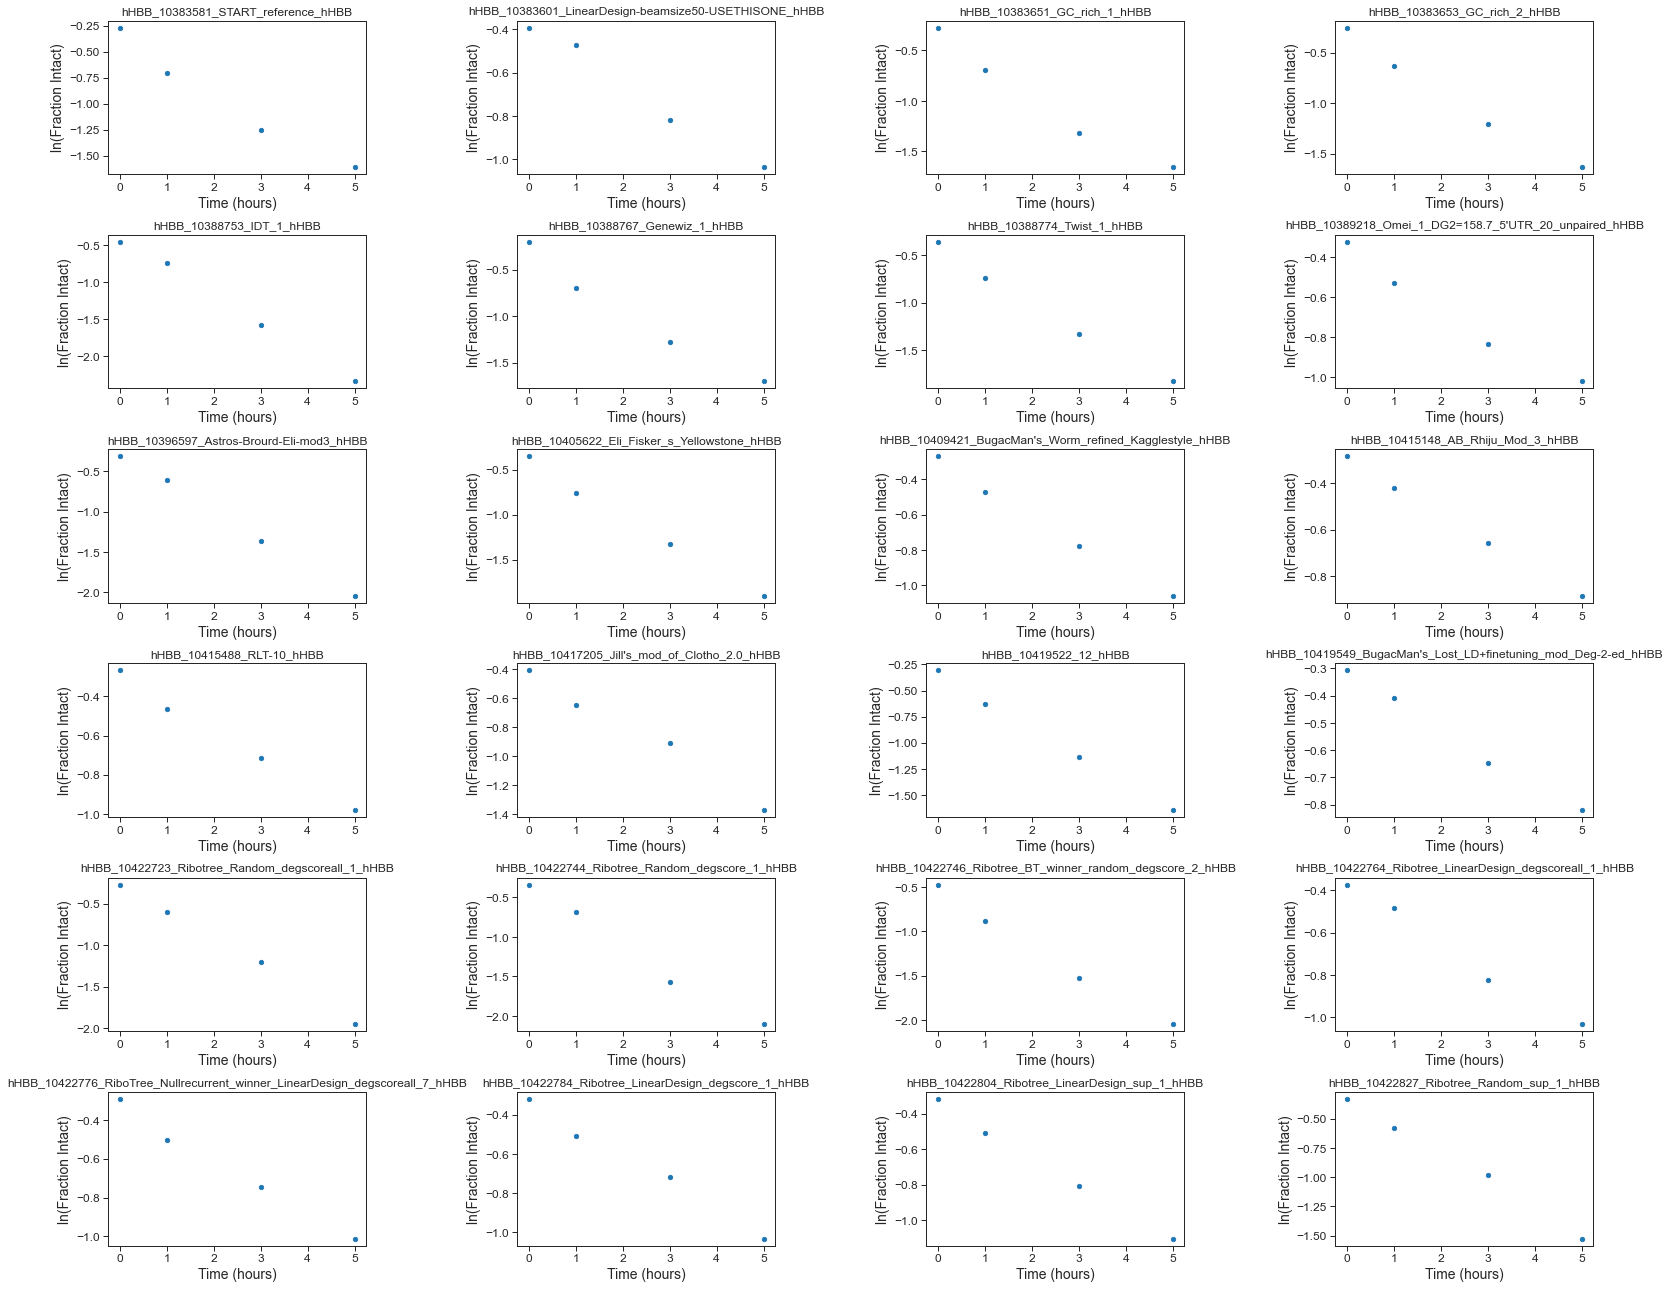

In [16]:
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))

num_plots = len(samples)
num_rows = round(num_plots/4, 1)
num_columns = num_plots/num_rows
figure(figsize=(num_rows*3+5, num_columns*4+2))
# sample_dfs = []
# sample_fits = {}
# all_fits = {}

for i, sample in tqdm(enumerate(sorted(samples))):
    
    subplot(num_rows, num_columns, i+1)
    rna_sample = sample[0]
    nucleotide = sample[1]

    #extracting the df for that sample, nucleotide combo
    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
    
    #times are time points (t), fraction intact values (fi)
    #to be used in fi = np.exp(-b*t) fit for b coefficient --> kdeg calculation
    times = np.array(working_df['Timepoint'])
    frac_intact = np.array(working_df['fraction_intact'])
    
#     clf()
    scatter(times, np.log(frac_intact), s=20, marker='o')
    
    title('{}'.format(rna_sample), fontsize=12)
    xlabel('Time (hours)')
    ylabel('ln(Fraction Intact)')

tight_layout()

savefig(plot_dir+'logy.pdf')

In [70]:
test_df = map_df[map_df['Sample']=='hHBB_10383581_START_reference_hHBB']
test_times = np.array(test_df['Timepoint'])
test_fi = np.array(test_df['fraction_intact'])

# test_times
# test_fi

fit_coeffs=[]

for i in np.arange(0,10, 1):
    
    frac_intact = np.absolute(test_fi)

    #generate bootstrap indices
    bs_indices = bootstrap_inds(frac_intact)
#     print(bs_indices)
    if (len(set(bs_indices))==1):
        continue
#     print(bs_indices)

    #generating data for fit
    fit_t = [test_times[i] for i in bs_indices]
    fit_fracint = [frac_intact[i] for i in bs_indices]

    #doing a first order fit after log transform
    fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1, w=np.sqrt(fit_fracint))
#         fit = np.polyfit(fit_t, -1*np.log(fit_fracint), 1)

#     fit
    
    fit_coeffs.append(fit[0])

# fit_coeffs


# scatter(test_times, test_fi)

# # fit = np.polyfit(test_times, -1*np.log(test_fi),1, w=np.sqrt(test_fi))
# # fit
# plot(np.arange(0,24,0.05), test_fi[0]*np.exp(-1*fit[0]*np.arange(0,24,0.05)))

<Figure size 1656x1296 with 0 Axes>

0it [00:00, ?it/s]

Trying an exponential fit...('hHBB_10383581_START_reference_hHBB', 'PSU')
kdeg: 0.2814550155583904
kdeg_err: 0.05542294458810957


Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

1it [00:00,  4.43it/s]

Trying an exponential fit...('hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB', 'PSU')
kdeg: 0.13418577246999322
kdeg_err: 0.017468945451303522


Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

2it [00:00,  4.39it/s]

Trying an exponential fit...('hHBB_10383651_GC_rich_1_hHBB', 'PSU')
kdeg: 0.2910194271678973
kdeg_err: 0.053684713609452143


Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

3it [00:00,  4.32it/s]

Trying an exponential fit...('hHBB_10383653_GC_rich_2_hHBB', 'PSU')
kdeg: 0.2856167393845917
kdeg_err: 0.03731350258699187


Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

4it [00:00,  4.22it/s]

Trying an exponential fit...('hHBB_10388753_IDT_1_hHBB', 'PSU')
kdeg: 0.3785275454045176
kdeg_err: 0.027710132462181892


Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

5it [00:01,  4.02it/s]

Trying an exponential fit...('hHBB_10388767_Genewiz_1_hHBB', 'PSU')
kdeg: 0.3090960929754815
kdeg_err: 0.05932340057275297


Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

6it [00:01,  3.87it/s]

Trying an exponential fit...('hHBB_10388774_Twist_1_hHBB', 'PSU')
kdeg: 0.3003621969511602
kdeg_err: 0.02605034967482239


Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

7it [00:02,  2.90it/s]

Trying an exponential fit...("hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB", 'PSU')
kdeg: 0.14571103920043585
kdeg_err: 0.024552322874918542


Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

8it [00:02,  3.06it/s]

Trying an exponential fit...('hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB', 'PSU')
kdeg: 0.34737013507693926
kdeg_err: 0.017217073057019975


Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

9it [00:02,  3.12it/s]

Trying an exponential fit...('hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB', 'PSU')
kdeg: 0.31515059815656266
kdeg_err: 0.03158030981058633


Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

10it [00:02,  3.05it/s]

Trying an exponential fit...("hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB", 'PSU')
kdeg: 0.15991691353469162
kdeg_err: 0.013904415134374215


Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

11it [00:03,  3.04it/s]

Trying an exponential fit...('hHBB_10415148_AB_Rhiju_Mod_3_hHBB', 'PSU')
kdeg: 0.12098823911848225
kdeg_err: 0.004840440400632902


Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

12it [00:03,  3.06it/s]

Trying an exponential fit...('hHBB_10415488_RLT-10_hHBB', 'PSU')
kdeg: 0.1420617642947554
kdeg_err: 0.015013105665638411


Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

13it [00:03,  3.01it/s]

Trying an exponential fit...("hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB", 'PSU')
kdeg: 0.18515732457684106
kdeg_err: 0.024513124797528672


Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

14it [00:04,  2.91it/s]

Trying an exponential fit...('hHBB_10419522_12_hHBB', 'PSU')
kdeg: 0.26846760778481255
kdeg_err: 0.017218870307622966


Text(0.5, 1.0, 'hHBB_10419522_12_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

15it [00:04,  2.87it/s]

Trying an exponential fit...("hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB", 'PSU')
kdeg: 0.10554331593358461
kdeg_err: 0.007028100453676525


Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

16it [00:05,  2.74it/s]

Trying an exponential fit...('hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB', 'PSU')
kdeg: 0.32738397086193133
kdeg_err: 0.015114501718681485


Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

17it [00:05,  2.65it/s]

Trying an exponential fit...('hHBB_10422744_Ribotree_Random_degscore_1_hHBB', 'PSU')
kdeg: 0.3712978147164374
kdeg_err: 0.03271923340201395


Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

18it [00:05,  2.54it/s]

Trying an exponential fit...('hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB', 'PSU')
kdeg: 0.32558336183940095
kdeg_err: 0.03309048338432062


Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

19it [00:06,  2.47it/s]

Trying an exponential fit...('hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB', 'PSU')
kdeg: 0.13799151749573507
kdeg_err: 0.015134907035850778


Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

20it [00:06,  2.40it/s]

Trying an exponential fit...('hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB', 'PSU')
kdeg: 0.14260981216998445
kdeg_err: 0.017727249462040767


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

21it [00:07,  2.37it/s]

Trying an exponential fit...('hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB', 'PSU')
kdeg: 0.13760644004744216
kdeg_err: 0.015961801738333118


Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

22it [00:07,  2.36it/s]

Trying an exponential fit...('hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB', 'PSU')
kdeg: 0.15770803771858186
kdeg_err: 0.01015331096515299


Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

23it [00:08,  2.33it/s]

Trying an exponential fit...('hHBB_10422827_Ribotree_Random_sup_1_hHBB', 'PSU')
kdeg: 0.23189787503275053
kdeg_err: 0.014088842979539766


Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

24it [00:08,  2.79it/s]


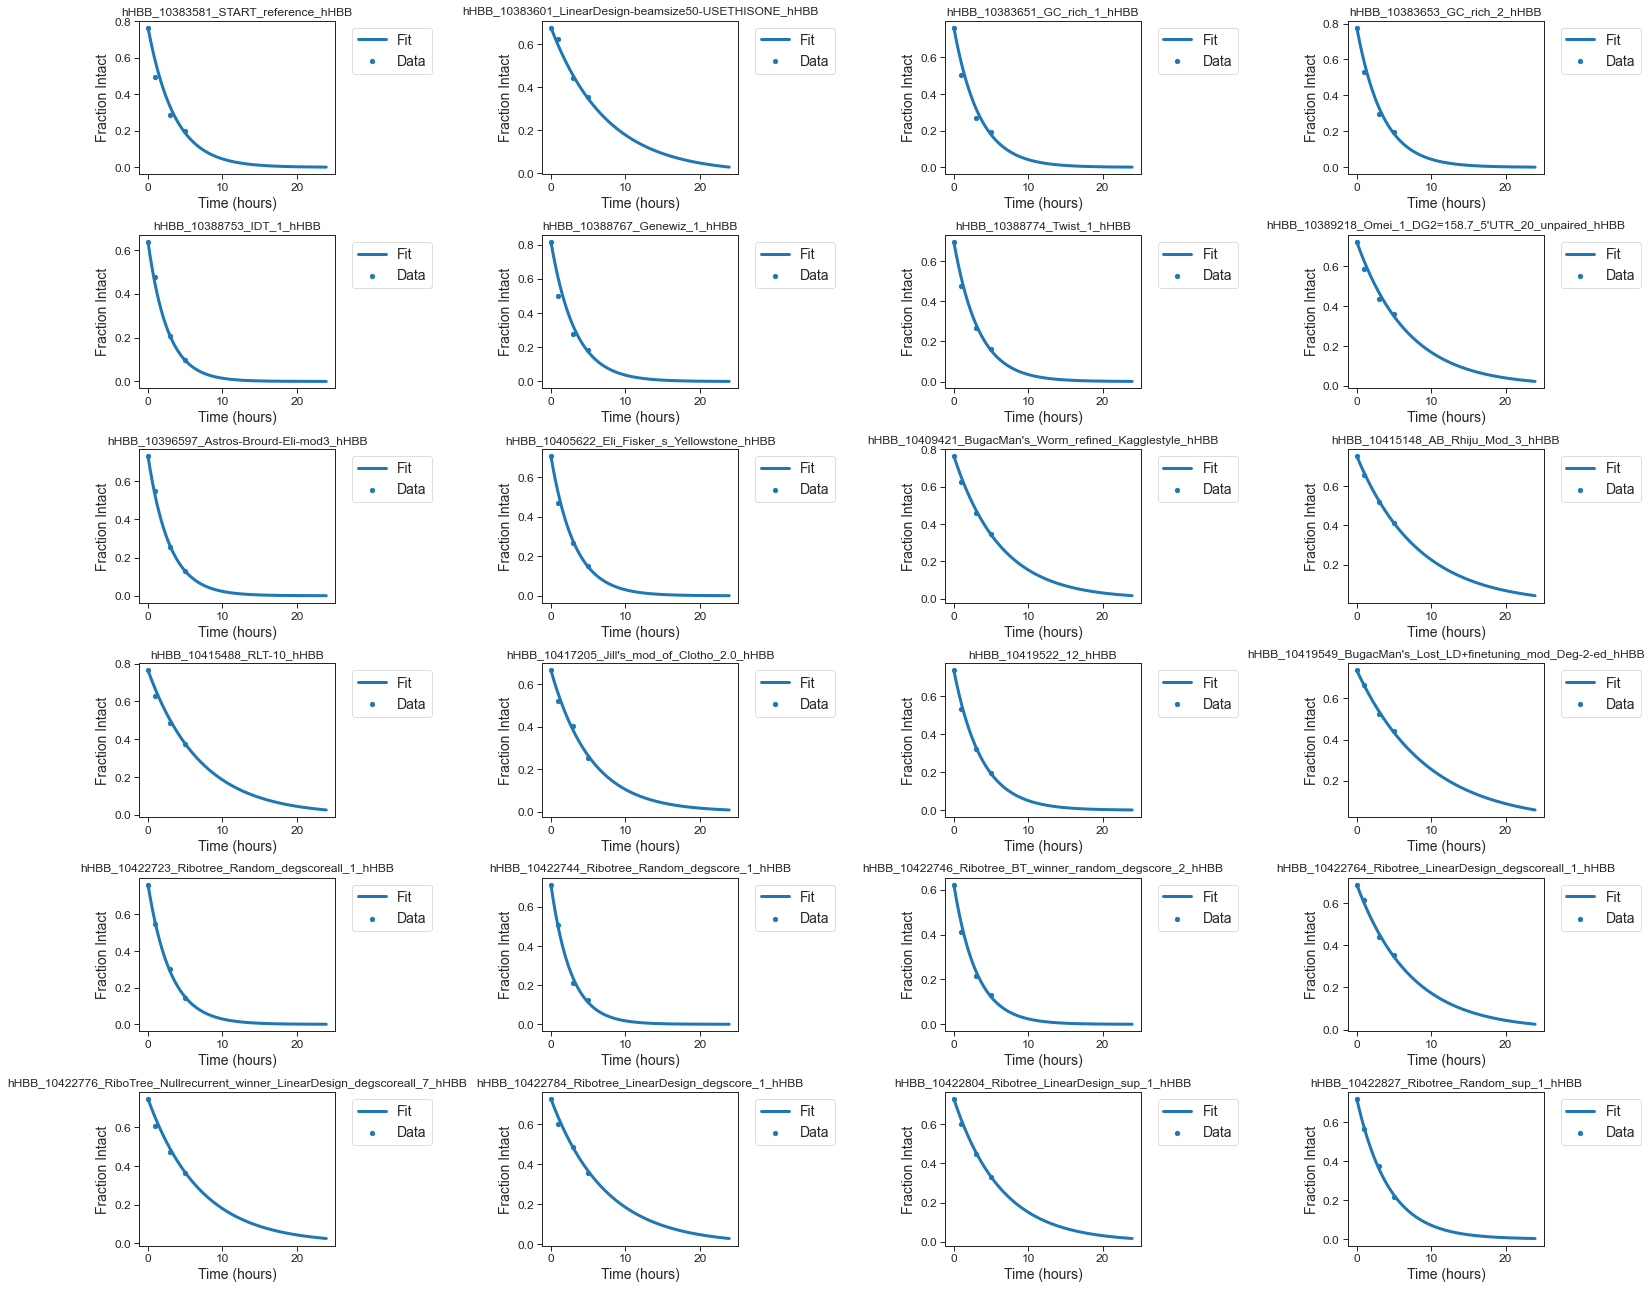

In [66]:
matplotlib.rcParams['pdf.fonttype'] = 42
plot_dir = './plots/'

#all combinations of sample and nucleotide type
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))
# samples=samples[0]

sample_dfs = []
sample_fits = {}
all_fits = {}

num_plots = len(samples)
num_rows = round(num_plots/4, 1)
num_columns = num_plots/num_rows
figure(figsize=(num_rows*3+5, num_columns*4+2))
sample_dfs = []
sample_fits = {}
all_fits = {}

for i, sample in tqdm(enumerate(sorted(samples))):
    
    subplot(num_rows, num_columns, i+1)
    
    rna_sample = sample[0]
    nucleotide = sample[1]

    #extracting the df for that sample, nucleotide combo
    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
    
    #times are time points (t), fraction intact values (fi)
    #to be used in fi = np.exp(-b*t) fit for b coefficient --> kdeg calculation
    times = np.array(working_df['Timepoint'])
    frac_intact = np.array(working_df['fraction_intact'])
    
#     times
#     frac_intact

    scatter(times, frac_intact, label='Data', s=20, marker='o')
    
    fit_dict = {}
    try:
        print('Trying an exponential fit...'+str(sample))
        fits = np.array(log_transform_fit(timepoints = times, frac_intact=frac_intact, bs_iter=1000))
#         fits
#         fit, cov = np.polyfit(times, -1*np.log(frac_intact), 1, w=np.sqrt(frac_intact), cov=True)
#         fit
#         cov
        kdeg = np.mean(fits)
        kdeg_err = np.std(fits)
        print('kdeg: '+str(kdeg))
        print('kdeg_err: '+str(kdeg_err))
        fit_dict['kdeg'] = kdeg
        fit_dict['kdeg_err'] = kdeg_err
        
#         plotting fit
        plot(np.arange(0,24,0.05), frac_intact[0]*np.exp(-1*kdeg*np.arange(0,24,0.05)), linewidth=3, label='Fit')

#     except LinAlgError:
#         print('Could not converge for...'+str(sample))
#         fit_dict['kdeg'] = 'Error'
#         fit_dict['kdeg_err'] = 'Error'
#         continue
    
    except RuntimeError:
        print('Could not converge for...'+str(sample))
        fit_dict['kdeg'] = 'Error'
        fit_dict['kdeg_err'] = 'Error'
        continue
    
    sample_fits[sample] = fit_dict
    all_fits[sample] = fits
    
    legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize=14)
    title('{}'.format(rna_sample), fontsize=12)
    xlabel('Time (hours)')
    ylabel('Fraction Intact')
    tight_layout()

savefig(plot_dir+'numpy_exponential_fit_bootstrapped.pdf')
#     clf()

In [67]:
pd.DataFrame.from_dict(sample_fits, orient='index').to_csv('12-02_expfits_bootstrapped.csv')

In [75]:
map_df['peak_area_subtracted'] = map_df['peak_area']-map_df['peak_background_area']
map_df['fraction_intact'] = map_df['peak_area_subtracted']/map_df['lane_background_area']
map_df['fraction_intact_nop4p6'] = map_df['peak_area_subtracted']/(map_df['lane_background_area']-map_df['p4p6_area'])
map_df.to_csv('12-02_areas_nop4p6.csv')

<Figure size 1656x1296 with 0 Axes>

0it [00:00, ?it/s]

Trying an exponential fit...('hHBB_10383581_START_reference_hHBB', 'PSU')
kdeg: 0.2585167505518176
kdeg_err: 0.05111771036248214


Text(0.5, 1.0, 'hHBB_10383581_START_reference_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

1it [00:00,  4.39it/s]

Trying an exponential fit...('hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB', 'PSU')
kdeg: 0.13022336101310045
kdeg_err: 0.018530203515595003


Text(0.5, 1.0, 'hHBB_10383601_LinearDesign-beamsize50-USETHISONE_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

2it [00:00,  4.38it/s]

Trying an exponential fit...('hHBB_10383651_GC_rich_1_hHBB', 'PSU')
kdeg: 0.27641733925589657
kdeg_err: 0.048862937414901136


Text(0.5, 1.0, 'hHBB_10383651_GC_rich_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

3it [00:00,  4.29it/s]

Trying an exponential fit...('hHBB_10383653_GC_rich_2_hHBB', 'PSU')
kdeg: 0.2662017390396723
kdeg_err: 0.029855449075614913


Text(0.5, 1.0, 'hHBB_10383653_GC_rich_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

4it [00:00,  4.20it/s]

Trying an exponential fit...('hHBB_10388753_IDT_1_hHBB', 'PSU')
kdeg: 0.35731215884641454
kdeg_err: 0.021287869042657826


Text(0.5, 1.0, 'hHBB_10388753_IDT_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

5it [00:01,  4.03it/s]

Trying an exponential fit...('hHBB_10388767_Genewiz_1_hHBB', 'PSU')
kdeg: 0.2898740461438895
kdeg_err: 0.05409025772084165


Text(0.5, 1.0, 'hHBB_10388767_Genewiz_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

6it [00:01,  3.87it/s]

Trying an exponential fit...('hHBB_10388774_Twist_1_hHBB', 'PSU')
kdeg: 0.2771968130556059
kdeg_err: 0.025152732038365624


Text(0.5, 1.0, 'hHBB_10388774_Twist_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

7it [00:01,  3.76it/s]

Trying an exponential fit...("hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB", 'PSU')
kdeg: 0.1392541553346851
kdeg_err: 0.023124121314176235


Text(0.5, 1.0, "hHBB_10389218_Omei_1_DG2=158.7_5'UTR_20_unpaired_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

8it [00:02,  3.62it/s]

Trying an exponential fit...('hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB', 'PSU')
kdeg: 0.32064697266351244
kdeg_err: 0.019934190562208076


Text(0.5, 1.0, 'hHBB_10396597_Astros-Brourd-Eli-mod3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

9it [00:02,  3.50it/s]

Trying an exponential fit...('hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB', 'PSU')
kdeg: 0.291865697967528
kdeg_err: 0.02956912071632377


Text(0.5, 1.0, 'hHBB_10405622_Eli_Fisker_s_Yellowstone_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

10it [00:02,  3.35it/s]

Trying an exponential fit...("hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB", 'PSU')
kdeg: 0.14932265846401918
kdeg_err: 0.009368080161413005


Text(0.5, 1.0, "hHBB_10409421_BugacMan's_Worm_refined_Kagglestyle_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

11it [00:03,  3.26it/s]

Trying an exponential fit...('hHBB_10415148_AB_Rhiju_Mod_3_hHBB', 'PSU')
kdeg: 0.111374494070914
kdeg_err: 0.006243194454087841


Text(0.5, 1.0, 'hHBB_10415148_AB_Rhiju_Mod_3_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

12it [00:03,  3.19it/s]

Trying an exponential fit...('hHBB_10415488_RLT-10_hHBB', 'PSU')
kdeg: 0.1339969275932433
kdeg_err: 0.011344468294169586


Text(0.5, 1.0, 'hHBB_10415488_RLT-10_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

13it [00:03,  3.09it/s]

Trying an exponential fit...("hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB", 'PSU')
kdeg: 0.17356832037626474
kdeg_err: 0.020585238824826116


Text(0.5, 1.0, "hHBB_10417205_Jill's_mod_of_Clotho_2.0_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

14it [00:04,  2.35it/s]

Trying an exponential fit...('hHBB_10419522_12_hHBB', 'PSU')
kdeg: 0.24377834237957802
kdeg_err: 0.010114832204017186


Text(0.5, 1.0, 'hHBB_10419522_12_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

15it [00:04,  2.42it/s]

Trying an exponential fit...("hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB", 'PSU')
kdeg: 0.100999016654265
kdeg_err: 0.0071088577466636976


Text(0.5, 1.0, "hHBB_10419549_BugacMan's_Lost_LD+finetuning_mod_Deg-2-ed_hHBB")

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

16it [00:05,  2.43it/s]

Trying an exponential fit...('hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB', 'PSU')
kdeg: 0.3103418809335041
kdeg_err: 0.012829198246277635


Text(0.5, 1.0, 'hHBB_10422723_Ribotree_Random_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

17it [00:05,  2.45it/s]

Trying an exponential fit...('hHBB_10422744_Ribotree_Random_degscore_1_hHBB', 'PSU')
kdeg: 0.34861541602015916
kdeg_err: 0.031534455934071254


Text(0.5, 1.0, 'hHBB_10422744_Ribotree_Random_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

18it [00:05,  2.44it/s]

Trying an exponential fit...('hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB', 'PSU')
kdeg: 0.2969688842416666
kdeg_err: 0.02469518437604626


Text(0.5, 1.0, 'hHBB_10422746_Ribotree_BT_winner_random_degscore_2_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

19it [00:06,  2.42it/s]

Trying an exponential fit...('hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB', 'PSU')
kdeg: 0.13611846479546982
kdeg_err: 0.016165009802156502


Text(0.5, 1.0, 'hHBB_10422764_Ribotree_LinearDesign_degscoreall_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

20it [00:06,  2.38it/s]

Trying an exponential fit...('hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB', 'PSU')
kdeg: 0.13304899329801675
kdeg_err: 0.01281202723011845


Text(0.5, 1.0, 'hHBB_10422776_RiboTree_Nullrecurrent_winner_LinearDesign_degscoreall_7_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

21it [00:07,  2.33it/s]

Trying an exponential fit...('hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB', 'PSU')
kdeg: 0.1314505853321982
kdeg_err: 0.012560470881314739


Text(0.5, 1.0, 'hHBB_10422784_Ribotree_LinearDesign_degscore_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

22it [00:07,  2.29it/s]

Trying an exponential fit...('hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB', 'PSU')
kdeg: 0.15079516838204968
kdeg_err: 0.006319481192171199


Text(0.5, 1.0, 'hHBB_10422804_Ribotree_LinearDesign_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

23it [00:08,  2.26it/s]

Trying an exponential fit...('hHBB_10422827_Ribotree_Random_sup_1_hHBB', 'PSU')
kdeg: 0.2211196862416729
kdeg_err: 0.016241147270220708


Text(0.5, 1.0, 'hHBB_10422827_Ribotree_Random_sup_1_hHBB')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

24it [00:08,  2.77it/s]


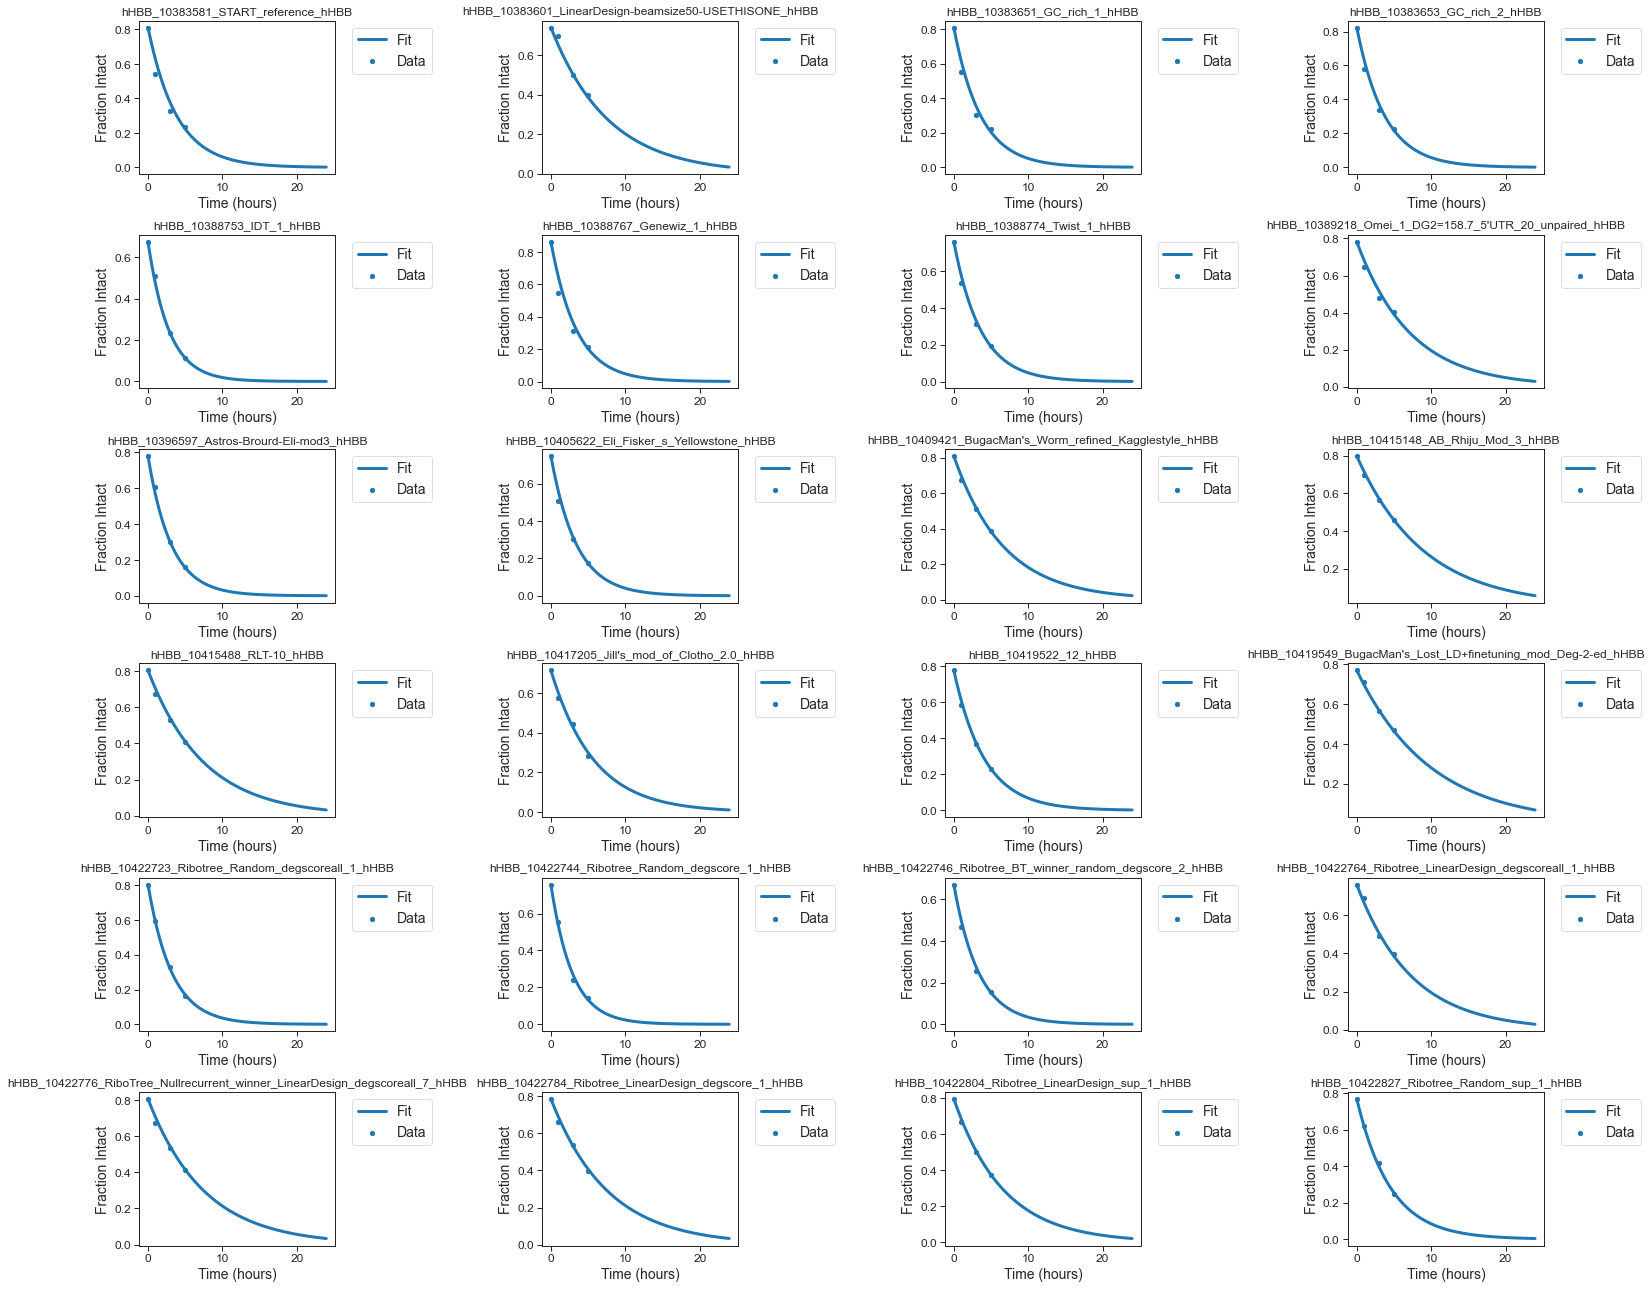

In [74]:
matplotlib.rcParams['pdf.fonttype'] = 42
plot_dir = './plots/'

#all combinations of sample and nucleotide type
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))
# samples=samples[0]

sample_dfs = []
sample_fits_nop4p6 = {}
all_fits_nop4p6 = {}

num_plots = len(samples)
num_rows = round(num_plots/4, 1)
num_columns = num_plots/num_rows
figure(figsize=(num_rows*3+5, num_columns*4+2))

for i, sample in tqdm(enumerate(sorted(samples))):
    
    subplot(num_rows, num_columns, i+1)
    
    rna_sample = sample[0]
    nucleotide = sample[1]

    #extracting the df for that sample, nucleotide combo
    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
    
    #times are time points (t), fraction intact values (fi)
    #to be used in fi = np.exp(-b*t) fit for b coefficient --> kdeg calculation
    times = np.array(working_df['Timepoint'])
    frac_intact = np.array(working_df['fraction_intact_nop4p6'])
    
#     times
#     frac_intact

    scatter(times, frac_intact, label='Data', s=20, marker='o')
    
    fit_dict = {}
    try:
        print('Trying an exponential fit...'+str(sample))
        fits = np.array(log_transform_fit(timepoints = times, frac_intact=frac_intact, bs_iter=1000))
#         fits
#         fit, cov = np.polyfit(times, -1*np.log(frac_intact), 1, w=np.sqrt(frac_intact), cov=True)
#         fit
#         cov
        kdeg = np.mean(fits)
        kdeg_err = np.std(fits)
        print('kdeg: '+str(kdeg))
        print('kdeg_err: '+str(kdeg_err))
        fit_dict['kdeg'] = kdeg
        fit_dict['kdeg_err'] = kdeg_err
        
#         plotting fit
        plot(np.arange(0,24,0.05), frac_intact[0]*np.exp(-1*kdeg*np.arange(0,24,0.05)), linewidth=3, label='Fit')

#     except LinAlgError:
#         print('Could not converge for...'+str(sample))
#         fit_dict['kdeg'] = 'Error'
#         fit_dict['kdeg_err'] = 'Error'
#         continue
    
    except RuntimeError:
        print('Could not converge for...'+str(sample))
        fit_dict['kdeg'] = 'Error'
        fit_dict['kdeg_err'] = 'Error'
        continue
    
    sample_fits_nop4p6[sample] = fit_dict
    all_fits_nop4p6[sample] = fits
    
    legend(loc='upper left', bbox_to_anchor=(1.05,1), fontsize=14)
    title('{}'.format(rna_sample), fontsize=12)
    xlabel('Time (hours)')
    ylabel('Fraction Intact')
    tight_layout()

savefig(plot_dir+'numpy_exponential_fit_bootstrapped_nop4p6.pdf')
#     clf()

pd.DataFrame.from_dict(sample_fits_nop4p6, orient='index').to_csv('12-02_expfits_bootstrapped_nop4p6.csv')